## Counter für Parteien und Zeitperioden

Ziel dieses Notebooks ist es, die Datei nach bestimmten Parteien zu durchsuchen, sowie eine Einteilung in die Zeiten vor, während und nach der Europawahl zu unterteilen sowie die Entwicklung der Parteien in diesen Zeiträumen

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# CSV-Datei laden
data = pd.read_csv('/content/bereinigte_datei.csv')  # Datei-Pfad hier angeben

Für die Schlagwortsuche haben wir uns für die 5 Parteien entschieden, die bei der Europawahl in Deutschland am meisten Stimmen erhalten haben

In [ ]:
# Schlagwortsuche nach Parteien (Beispiel mit drei Parteien)
parteien = {
    "CDU/CSU": ["cdu", "csu", "söder", "merz"],
    "AFD": ["afd", "höcke", "weidel", "chrupalla"],
    "SPD": ["spd", "scholz", "kühnert", "klingbeil"],
    "Die Grünen": ["grünen", "habeck", "baerbock"],
    "BSW": ["bsw", "wagenknecht"]
}

In [ ]:
# Spalte für Parteienzuordnung
data['partei'] = None # Changed from pd.DataFrame to data

for partei, keywords in parteien.items():
    data.loc[data['text'].str.contains('|'.join(keywords), case=False, na=False), 'partei'] = partei


In [ ]:
# Definiere die Reihenfolge der Parteien als kategorische Variable
partei_order = ["CDU/CSU", "AFD", "SPD", "Die Grünen", "BSW"]
data['partei'] = pd.Categorical(data['partei'], categories=partei_order, ordered=True)

In [ ]:
# Farben für Sentiment festlegen: 0 = neutral (blau), 1 = negativ (rot), 2 = positiv (grün)
sentiment_colors = ['#87CEEB', '#FF7F7F', '#90EE90']
sentiment_labels = {0: 'neutral', 1: 'negativ', 2: 'positiv'}

<ipython-input-34-9422ce681b23>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  parteien_sentiment_counts = data.groupby(['partei', 'label']).size().unstack(fill_value=0)


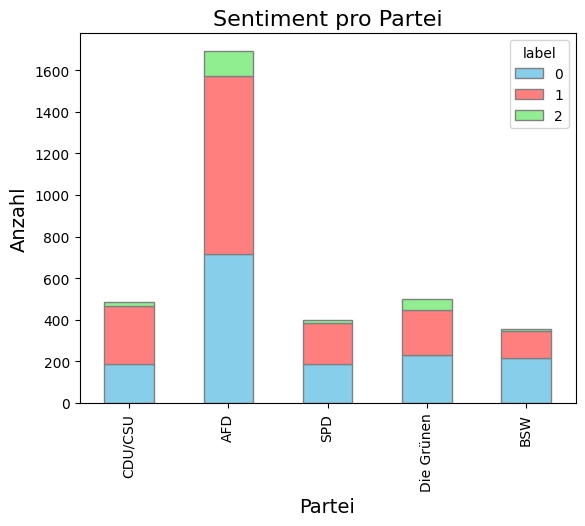

In [ ]:
# Gestapeltes Balkendiagramm für alle Parteien und Sentiment
parteien_sentiment_counts = data.groupby(['partei', 'label']).size().unstack(fill_value=0)
parteien_sentiment_counts.plot(kind='bar', stacked=True, color=sentiment_colors, edgecolor='grey')
plt.title('Sentiment pro Partei', fontsize=16)
plt.xlabel('Partei', fontsize=14)
plt.ylabel('Anzahl', fontsize=14)
plt.show()

In [ ]:
# Print der Sentiment-Zahlen für jede Partei
print("Anzahl der Sentiments pro Partei:")
for partei in parteien_sentiment_counts.index:
    print(f"Partei: {partei}")
    for sentiment, count in parteien_sentiment_counts.loc[partei].items():
        print(f"  {sentiment_labels[sentiment]}: {count}")
    print()  # Leere Zeile für bessere Übersichtlichkeit

Anzahl der Sentiments pro Partei:
Partei: CDU/CSU
  neutral: 188
  negativ: 277
  positiv: 19

Partei: AFD
  neutral: 717
  negativ: 854
  positiv: 121

Partei: SPD
  neutral: 186
  negativ: 200
  positiv: 14

Partei: Die Grünen
  neutral: 230
  negativ: 215
  positiv: 57

Partei: BSW
  neutral: 218
  negativ: 129
  positiv: 10



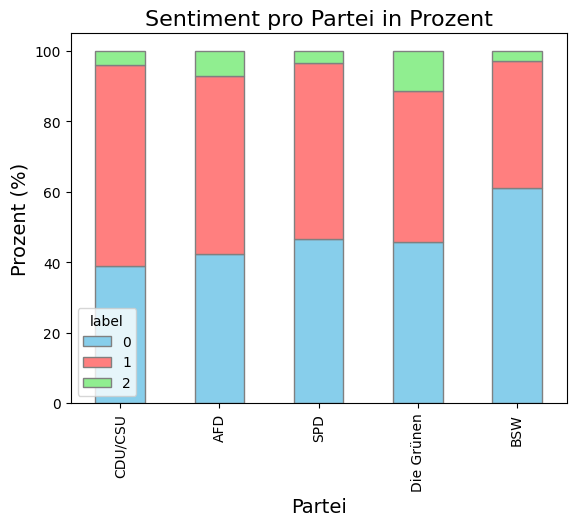

In [ ]:
# Prozentuales gestapeltes Balkendiagramm
parteien_sentiment_percent = parteien_sentiment_counts.div(parteien_sentiment_counts.sum(axis=1), axis=0) * 100
parteien_sentiment_percent.plot(kind='bar', stacked=True, color=sentiment_colors, edgecolor='grey')
plt.title('Sentiment pro Partei in Prozent', fontsize=16)
plt.xlabel('Partei', fontsize=14)
plt.ylabel('Prozent (%)', fontsize=14)
plt.show()

In [ ]:
# Daten in Zeiträume einteilen und Sentiments zählen
def split_by_time_periods(data, time_periods):
    sentiment_data = {}

    for i, (start_time, end_time) in enumerate(time_periods):
        # Convert start_time and end_time to datetime objects with UTC timezone
        start_time = pd.to_datetime(start_time, utc=True)  # Zeitzone auf UTC setzen
        end_time = pd.to_datetime(end_time, utc=True)  # Zeitzone auf UTC setzen

        # Convert 'created_at' column to datetime objects with UTC timezone
        # Use infer_datetime_format=True to handle various date formats
        data['created_at'] = pd.to_datetime(data['created_at'], utc=True, infer_datetime_format=True, errors='coerce')

        # Filterung der Daten nach dem Zeitbereich inkl. Uhrzeit
        period_data = data[(data['created_at'] >= start_time) & (data['created_at'] <= end_time)]

        # Zählen der Werte 0, 1 und 2 in der Sentiment-Spalte
        sentiment_counts = period_data['label'].value_counts().reindex([0, 1, 2], fill_value=0)

        # Speicherung der Sentiment-Zusammenfassung für diesen Zeitraum
        sentiment_data[f"Zeitraum {i+1} ({start_time} bis {end_time})"] = sentiment_counts

    return sentiment_data

# Counter, der die Sentiment-Zahlen ausgibt
def print_sentiment_counts(sentiment_data):
    zeitraeume = ["vor", "während", "nach"]

    for i, zeitraum in enumerate(sentiment_data.keys()):
        print(f"Sentiment-Zusammenfassung für Zeitraum '{zeitraeume[i]}':")
        print(f"  Sentiment 0 (Neutral): {sentiment_data[zeitraum][0]}")
        print(f"  Sentiment 1 (Negativ): {sentiment_data[zeitraum][1]}")
        print(f"  Sentiment 2 (Positiv): {sentiment_data[zeitraum][2]}")
        print()

# Visualisierung der prozentualen Sentiments pro Zeitperiode
def plot_sentiment_percentages(sentiment_data):
    # Angepasste Labels für die Zeiträume
    zeitraeume = ["vor", "während", "nach"]

    sentiment_percentages = {}

    # Prozentuale Verteilung berechnen
    for zeitraum, counts in sentiment_data.items():
        total = sum(counts)  # counts is a NumPy array, so directly sum its elements
        if total > 0:
            sentiment_percentages[zeitraum] = {
                0: (counts[0] / total) * 100,
                1: (counts[1] / total) * 100,
                2: (counts[2] / total) * 100
            }
        else:
            sentiment_percentages[zeitraum] = {0: 0, 1: 0, 2: 0}

    sentiment_0 = [sentiment_percentages[zeitraum][0] for zeitraum in sentiment_data.keys()]
    sentiment_1 = [sentiment_percentages[zeitraum][1] for zeitraum in sentiment_data.keys()]
    sentiment_2 = [sentiment_percentages[zeitraum][2] for zeitraum in sentiment_data.keys()]

    # Balkendiagramm für Prozentwerte erstellen
    plt.figure(figsize=(10, 6))
    r1 = range(len(zeitraeume))

    bars1 = plt.bar(r1, sentiment_0, color='#87CEEB', edgecolor='grey', label='Sentiment 0 (Neutral)')
    bars2 = plt.bar(r1, sentiment_1, bottom=sentiment_0, color='#FF7F7F', edgecolor='grey', label='Sentiment 1 (Negativ)')
    bars3 = plt.bar(r1, sentiment_2, bottom=[i+j for i,j in zip(sentiment_0, sentiment_1)], color='#90EE90', edgecolor='grey', label='Sentiment 2 (Positiv)')

    # Prozentzahlen in den Balken anzeigen (ohne % Zeichen), schön zentriert
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height / 2, f'{sentiment_0[i]:.1f}', ha='center', va='center', color='black', fontsize=14)

    for i, bar in enumerate(bars2):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, sentiment_0[i] + height / 2, f'{sentiment_1[i]:.1f}', ha='center', va='center', color='black', fontsize=14)

    for i, bar in enumerate(bars3):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, sentiment_0[i] + sentiment_1[i] + height / 2, f'{sentiment_2[i]:.1f}', ha='center', va='center', color='black', fontsize=14)

    # Diagramm beschriften
    plt.xlabel('Zeiträume', fontsize=14)
    plt.ylabel('Prozentuale Verteilung der Sentiments (%)', fontsize=14)
    plt.title('Prozentuale Sentiment-Verteilung vor, während und nach der Europawahl', fontsize=16)
    plt.xticks(r1, zeitraeume, rotation=45, ha="right", fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='lower left')

    # Diagramm anzeigen
    plt.tight_layout()
    plt.show()

# Analyse der Parteianalyse und Sentimentverteilung pro Partei
def analyze_sentiments_per_party(data, time_periods, sentiment_colors, sentiment_labels, labels):
    # Daten für die Zeiträume analysieren
    for i, (start, end) in enumerate(time_periods):
        # Daten des Zeitraums filtern
        zeitraum_data = data[(data['created_at'] >= start) & (data['created_at'] <= end)]
        zeitraum_sentiment_counts = zeitraum_data['label'].value_counts().reindex([0, 1, 2], fill_value=0)
        print(f"Zeitraum: {labels[i]}")
        print(zeitraum_sentiment_counts)

        # Balkendiagramm der Sentimentverteilung für jeden Zeitraum
        ax = zeitraum_sentiment_counts.plot(kind='bar', color=sentiment_colors, edgecolor='grey')
        plt.title(f'Sentimentverteilung {labels[i]} der Europawahl', fontsize=16)
        plt.xlabel('Sentiment', fontsize=14)
        plt.ylabel('Anzahl', fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)

        # Setze die richtigen Namen für die Sentiments als X-Achsenbeschriftung
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels([sentiment_labels[x] for x in zeitraum_sentiment_counts.index])

        # Zahlen auf den Balken anzeigen
        for p in ax.patches:
            ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=14, color='black')

        plt.show()

        # Prozentuales Balkendiagramm
        zeitraum_sentiment_percent = (zeitraum_sentiment_counts / zeitraum_sentiment_counts.sum()) * 100
        ax = zeitraum_sentiment_percent.plot(kind='bar', color=sentiment_colors, edgecolor='grey')
        plt.title(f'Prozentuale Sentimentverteilung {labels[i]} der Europawahl', fontsize=16)
        plt.xlabel('Sentiment', fontsize=14)
        plt.ylabel('Prozent (%)', fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)

        # Setze die richtigen Namen für die Sentiments als X-Achsenbeschriftung
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels([sentiment_labels[x] for x in zeitraum_sentiment_counts.index])

        # Zahlen auf den Balken anzeigen
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom', fontsize=12, color='black')

        plt.show()

        # Parteienanalyse in den Zeiträumen
        zeitraum_partei_sentiment_counts = zeitraum_data.groupby(['partei', 'label']).size().unstack(fill_value=0)
        print(f"\nZeitraum: {labels[i]} - Sentiment pro Partei (absolute Zahlen)")
        print(zeitraum_partei_sentiment_counts)

        # Berechne und printe die prozentuale Verteilung für jede Partei
        zeitraum_partei_sentiment_percent = zeitraum_partei_sentiment_counts.div(zeitraum_partei_sentiment_counts.sum(axis=1), axis=0) * 100
        zeitraum_partei_sentiment_percent = zeitraum_partei_sentiment_percent.round(2)
        print(f"Zeitraum: {labels[i]} - Sentiment pro Partei (Prozent)")
        print(zeitraum_partei_sentiment_percent)

        # Balkendiagramm für Parteien in Zeiträumen
        zeitraum_partei_sentiment_counts.plot(kind='bar', stacked=True, color=sentiment_colors, edgecolor='grey')
        plt.title(f'Sentiment pro Partei {labels[i]} der Europawahl', fontsize=16)
        plt.xlabel('Partei', fontsize=14)
        plt.ylabel('Anzahl', fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.show()

        # Prozentuales Balkendiagramm für Parteien in Zeiträumen
        zeitraum_partei_sentiment_percent.plot(kind='bar', stacked=True, color=sentiment_colors, edgecolor='grey')
        plt.title(f'Sentiment pro Partei {labels[i]} der Europawahl in Prozent', fontsize=16)
        plt.xlabel('Partei', fontsize=14)
        plt.ylabel('Prozent (%)', fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.show()



In [ ]:
# Hauptfunktion
def main(file_path, time_periods):
    # Daten in Zeitperioden aufteilen und Sentiment-Zusammenfassung erstellen
    sentiment_data = split_by_time_periods(data, time_periods)

    # Sentiment-Zahlen ausgeben
    print_sentiment_counts(sentiment_data)

    # Ergebnisse plotten (prozentuale Verteilung)
    plot_sentiment_percentages(sentiment_data)

    # Farben und Labels definieren
    sentiment_colors = ['#87CEEB', '#FF7F7F', '#90EE90']
    sentiment_labels = {0: "neutral", 1: "negativ", 2: "positiv"}
    labels = ["vor", "während", "nach"]

    # Parteienanalyse und Sentimentverteilung analysieren
    analyze_sentiments_per_party(data, time_periods, sentiment_colors, sentiment_labels, labels)

<ipython-input-37-22f84ad50c3a>:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['created_at'] = pd.to_datetime(data['created_at'], utc=True, infer_datetime_format=True, errors='coerce')
<ipython-input-37-22f84ad50c3a>:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['created_at'] = pd.to_datetime(data['created_at'], utc=True, infer_datetime_format=True, errors='coerce')
<ipython-input-37-22f84ad50c3a>:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the d

Sentiment-Zusammenfassung für Zeitraum 'vor':
  Sentiment 0 (Neutral): 4261
  Sentiment 1 (Negativ): 2237
  Sentiment 2 (Positiv): 2270

Sentiment-Zusammenfassung für Zeitraum 'während':
  Sentiment 0 (Neutral): 815
  Sentiment 1 (Negativ): 1075
  Sentiment 2 (Positiv): 332

Sentiment-Zusammenfassung für Zeitraum 'nach':
  Sentiment 0 (Neutral): 2755
  Sentiment 1 (Negativ): 2831
  Sentiment 2 (Positiv): 619



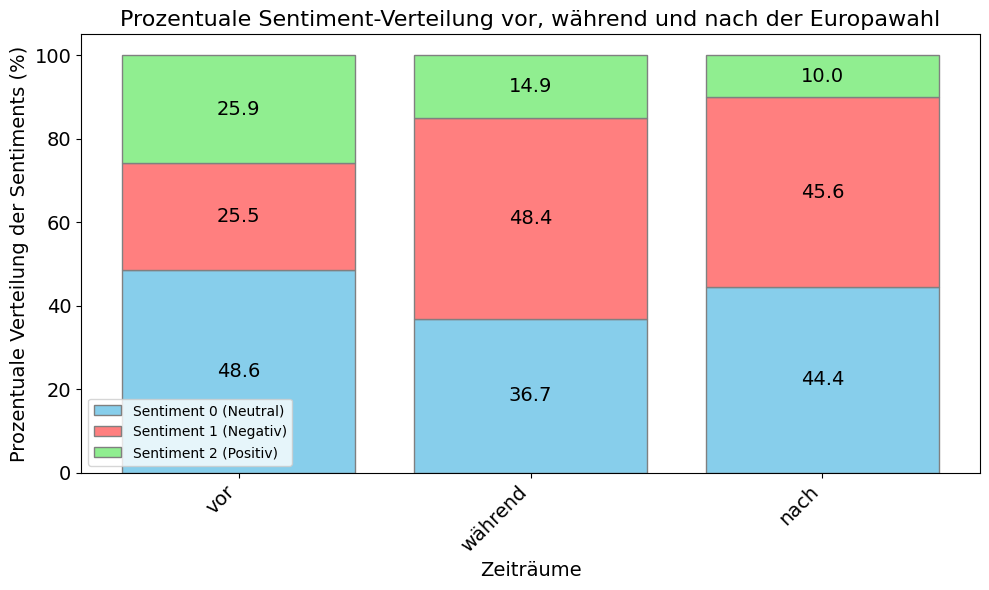

Zeitraum: vor
label
0    4261
1    2237
2    2270
Name: count, dtype: int64


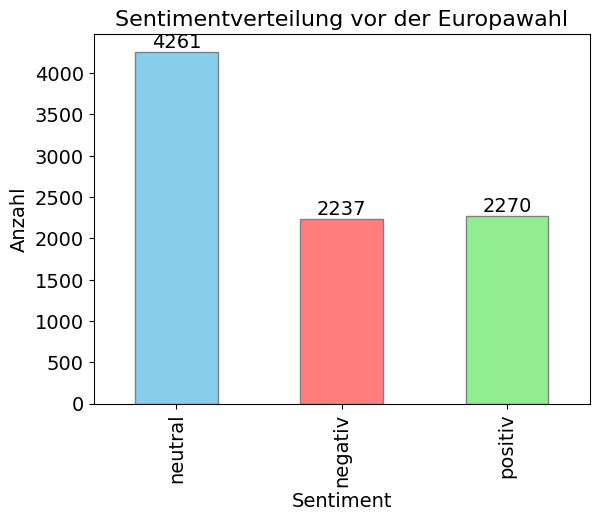

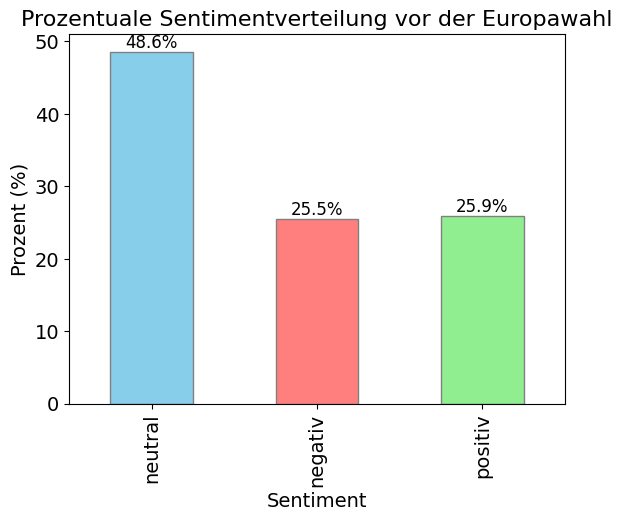

<ipython-input-37-22f84ad50c3a>:140: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zeitraum_partei_sentiment_counts = zeitraum_data.groupby(['partei', 'label']).size().unstack(fill_value=0)



Zeitraum: vor - Sentiment pro Partei (absolute Zahlen)
label         0    1   2
partei                  
CDU/CSU     121  152  13
AFD         371  306  77
SPD          75   59   5
Die Grünen   94   64  23
BSW          83   36   2
Zeitraum: vor - Sentiment pro Partei (Prozent)
label           0      1      2
partei                         
CDU/CSU     42.31  53.15   4.55
AFD         49.20  40.58  10.21
SPD         53.96  42.45   3.60
Die Grünen  51.93  35.36  12.71
BSW         68.60  29.75   1.65


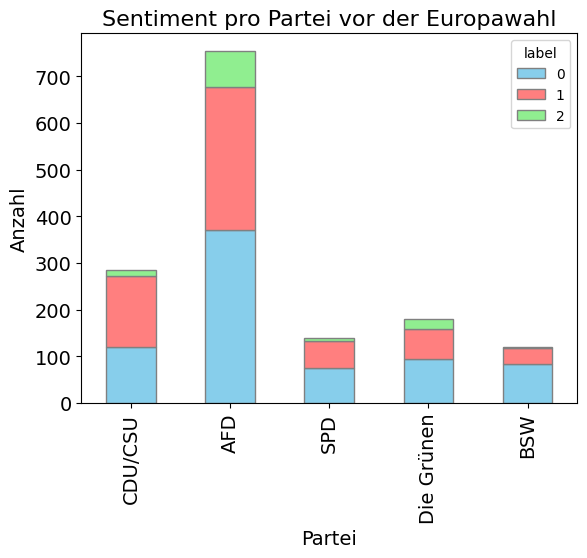

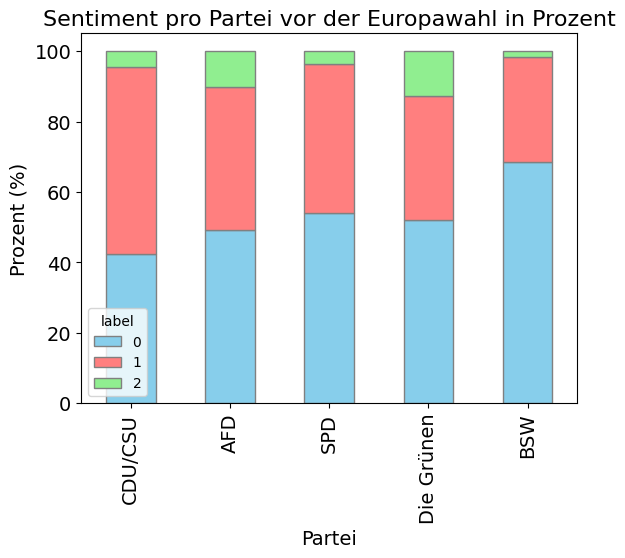

Zeitraum: während
label
0     815
1    1075
2     332
Name: count, dtype: int64


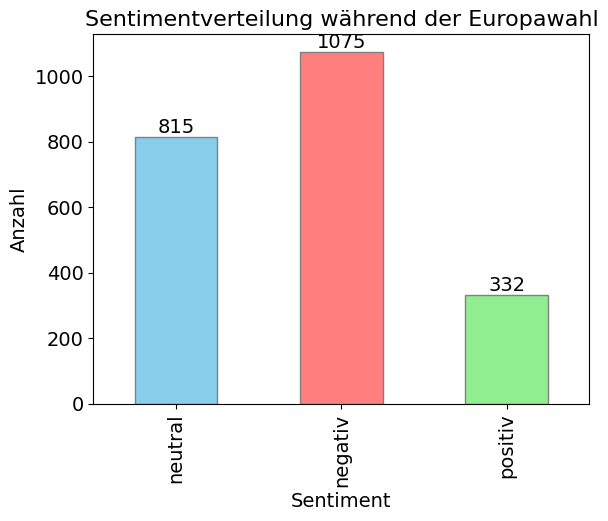

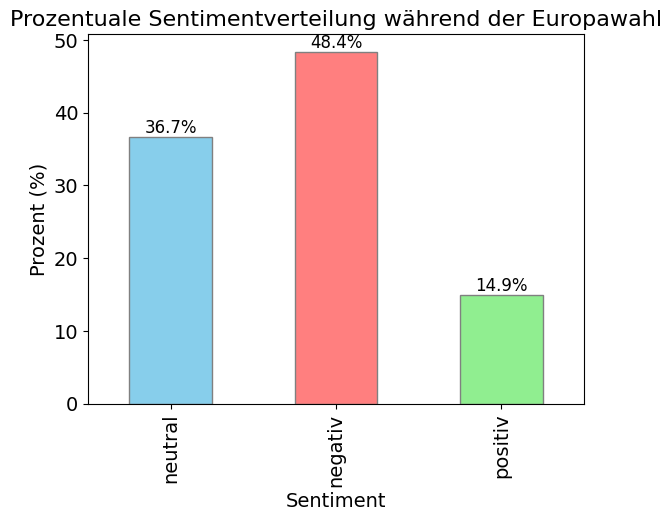

<ipython-input-37-22f84ad50c3a>:140: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zeitraum_partei_sentiment_counts = zeitraum_data.groupby(['partei', 'label']).size().unstack(fill_value=0)



Zeitraum: während - Sentiment pro Partei (absolute Zahlen)
label        0    1   2
partei                 
CDU/CSU      9   28   3
AFD         44  157  10
SPD         18   16   0
Die Grünen  19   32   6
BSW         15   32   1
Zeitraum: während - Sentiment pro Partei (Prozent)
label           0      1      2
partei                         
CDU/CSU     22.50  70.00   7.50
AFD         20.85  74.41   4.74
SPD         52.94  47.06   0.00
Die Grünen  33.33  56.14  10.53
BSW         31.25  66.67   2.08


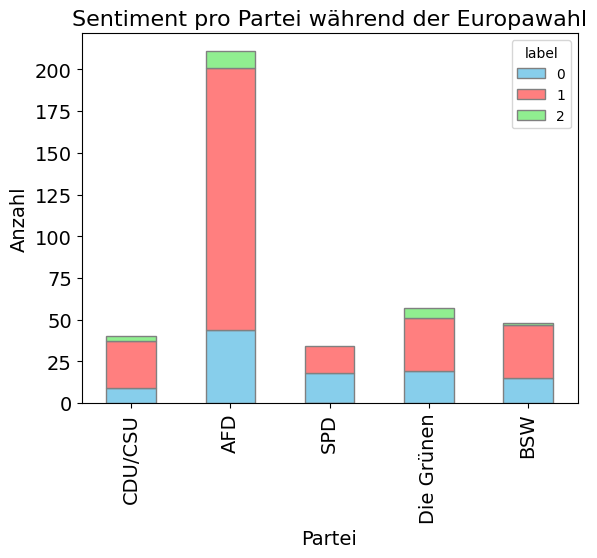

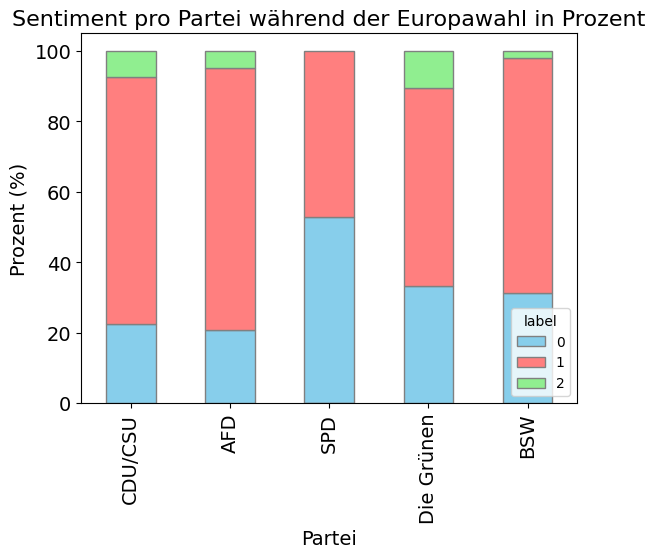

Zeitraum: nach
label
0    2755
1    2831
2     619
Name: count, dtype: int64


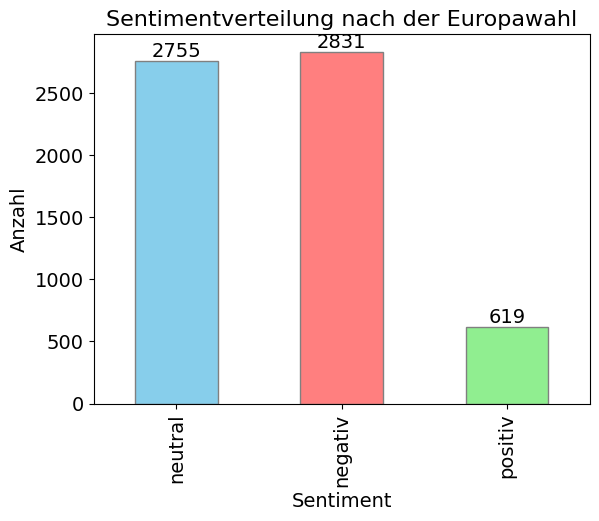

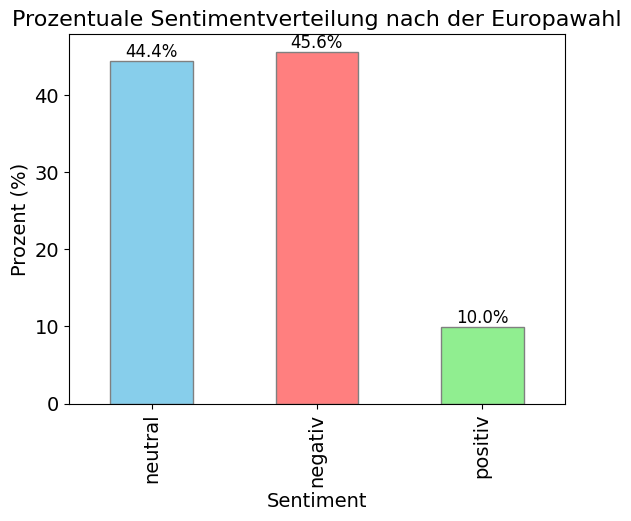

<ipython-input-37-22f84ad50c3a>:140: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zeitraum_partei_sentiment_counts = zeitraum_data.groupby(['partei', 'label']).size().unstack(fill_value=0)



Zeitraum: nach - Sentiment pro Partei (absolute Zahlen)
label         0    1   2
partei                  
CDU/CSU      56   97   3
AFD         270  387  34
SPD          83  121   9
Die Grünen  106  115  27
BSW         113   59   7
Zeitraum: nach - Sentiment pro Partei (Prozent)
label           0      1      2
partei                         
CDU/CSU     35.90  62.18   1.92
AFD         39.07  56.01   4.92
SPD         38.97  56.81   4.23
Die Grünen  42.74  46.37  10.89
BSW         63.13  32.96   3.91


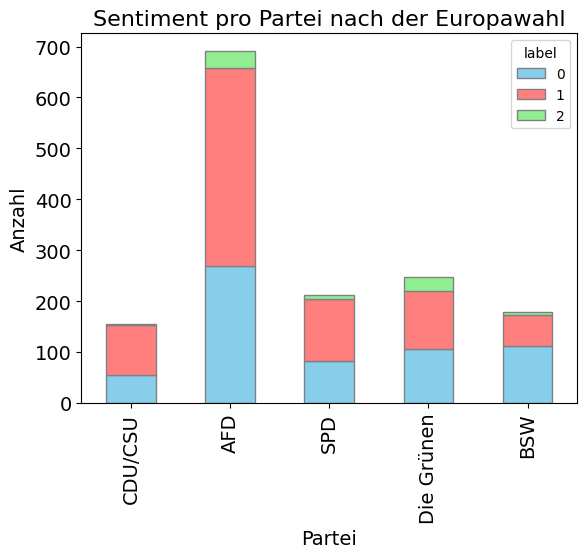

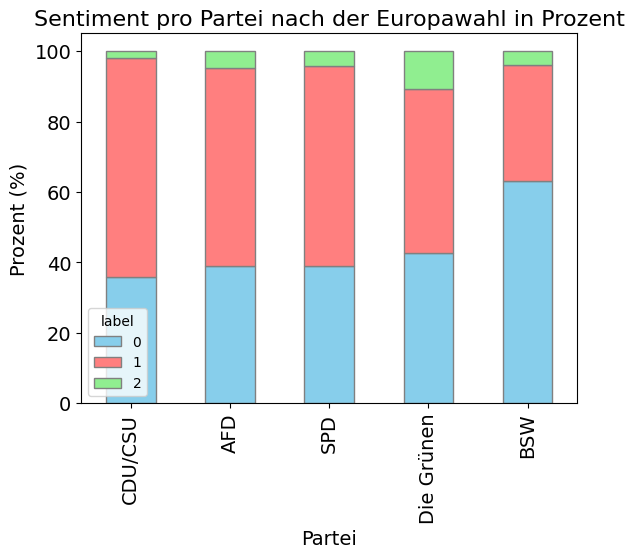

In [ ]:
# Beispielaufruf der Funktion
if __name__ == "__main__":
    file_path = "/content/bereinigte_datei.csv"  # Pfad zur CSV-Datei

    # Zeiträume mit Datum und Uhrzeit angeben (Beispiel)
    time_periods = [
        ("2024-05-06T14:46:27.974Z", "2024-06-09T07:59:18.504Z"),
        ("2024-06-09T08:00:18.086Z", "2024-06-09T17:59:55.454Z"),
        ("2024-06-09T18:00:01.415Z", "2024-08-29T21:32:11.095Z")
    ]

    # Aufruf der Hauptfunktion mit den angegebenen Zeitperioden
    main(file_path, time_periods)  # Analyse basierend auf Zeiträumen